In [6]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb
import imblearn

# Read and sanitize the data
df = pd.read_csv("../data/t00/data_t00.csv")
df_full = df.copy()
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()

cols = [col for col in df.columns if col != "min_offer"] + ["min_offer"]

In [7]:
from core.utils.preprocessing import df_to_xydf, df_to_xy

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


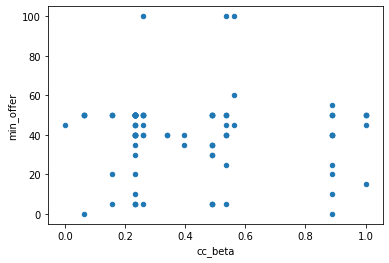

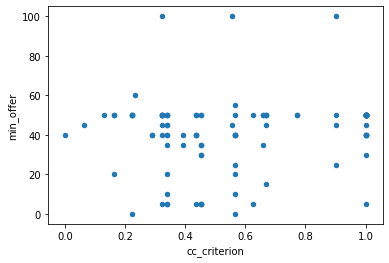

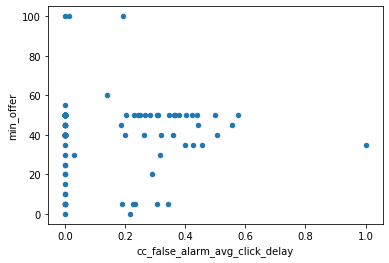

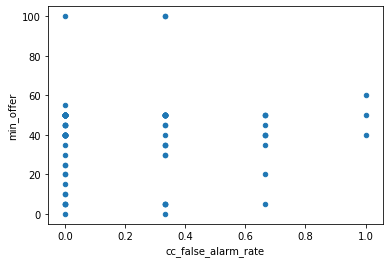

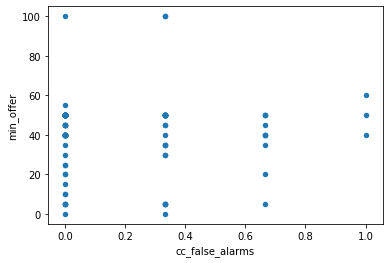

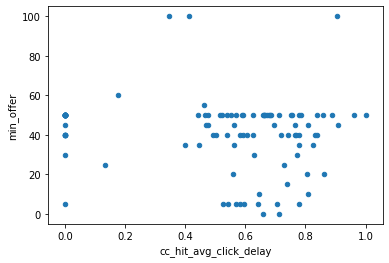

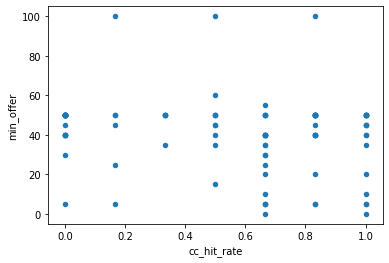

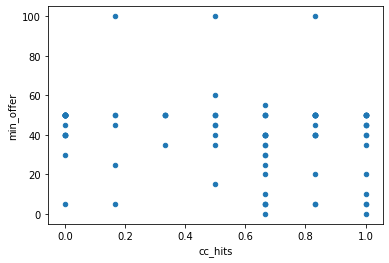

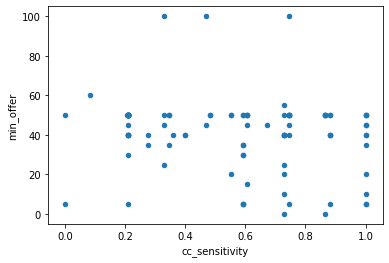

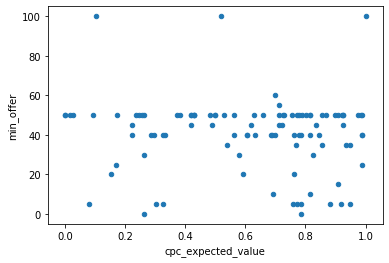

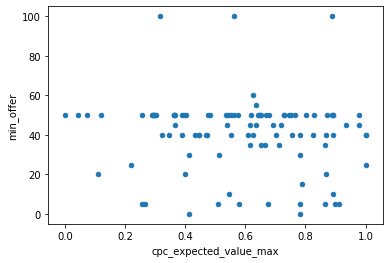

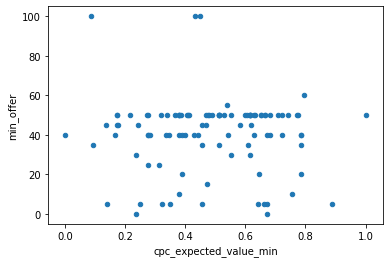

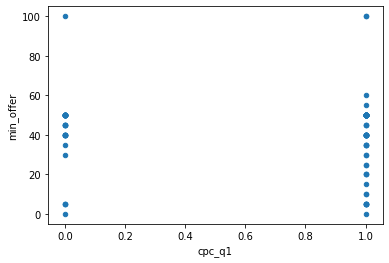

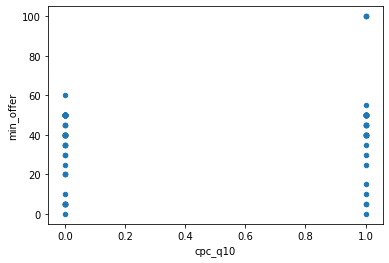

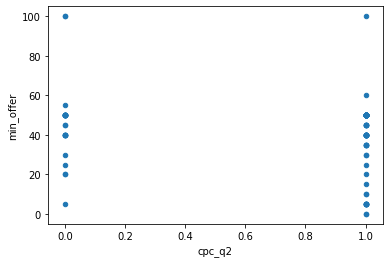

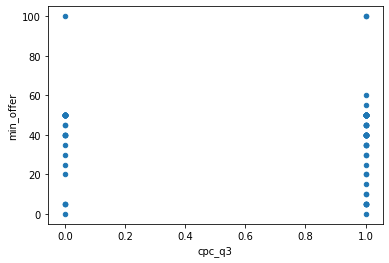

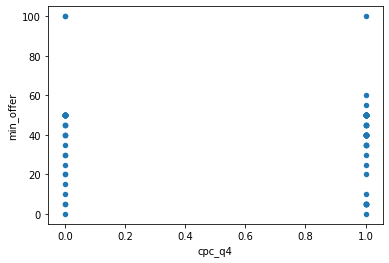

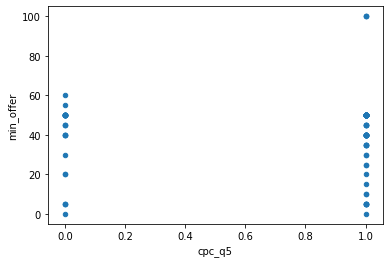

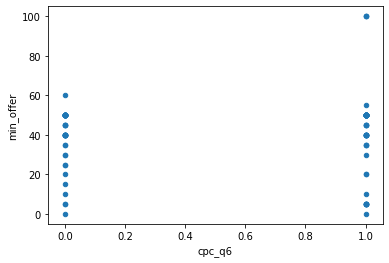

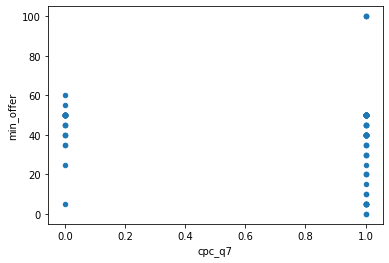

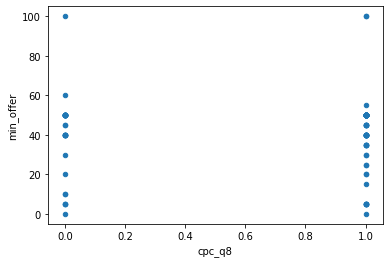

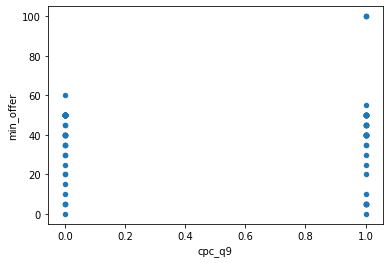

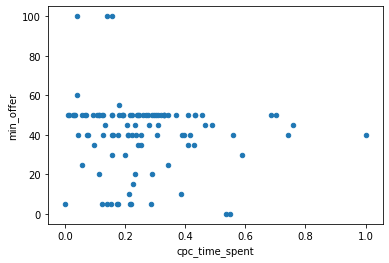

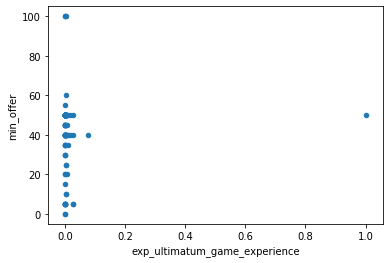

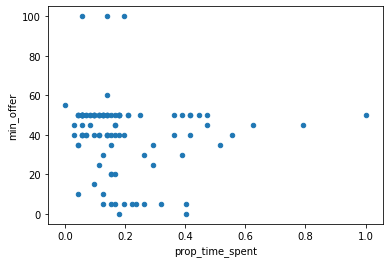

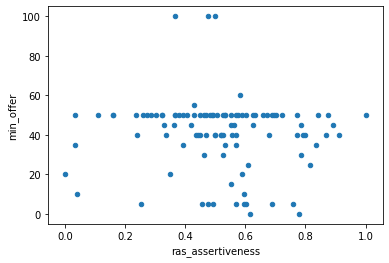

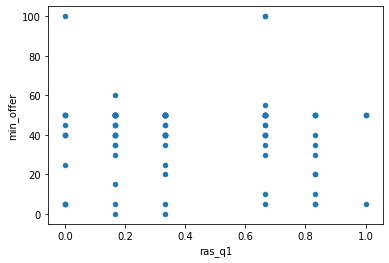

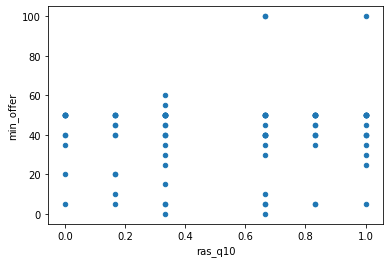

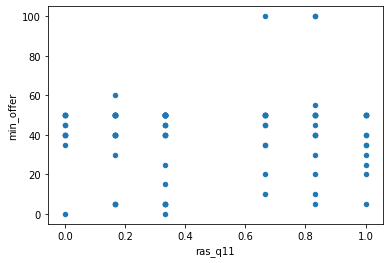

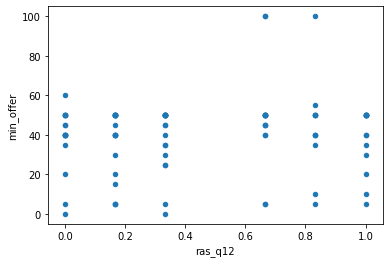

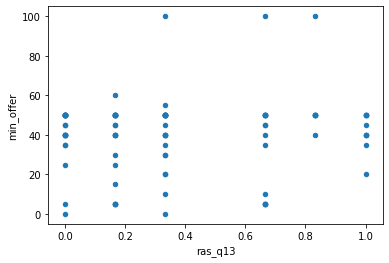

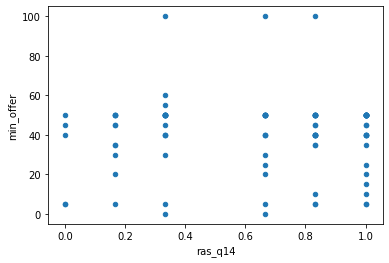

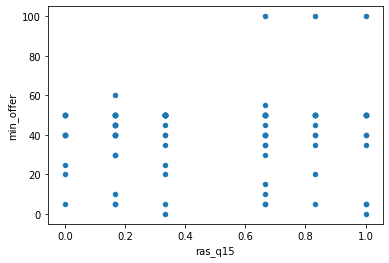

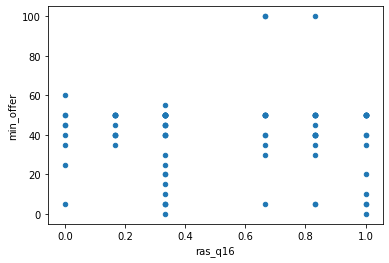

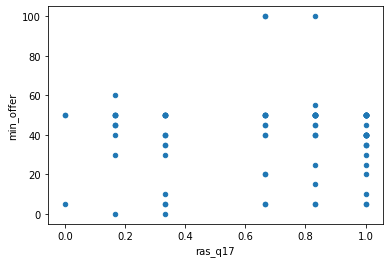

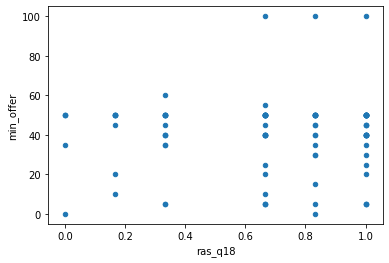

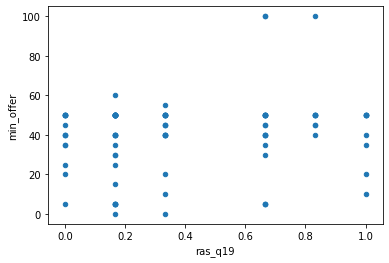

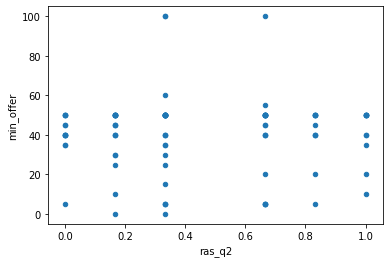

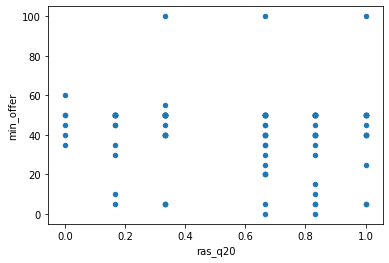

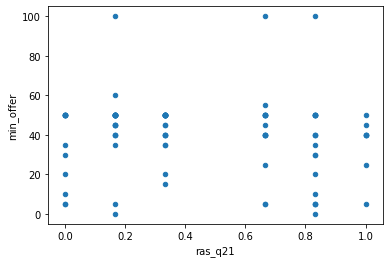

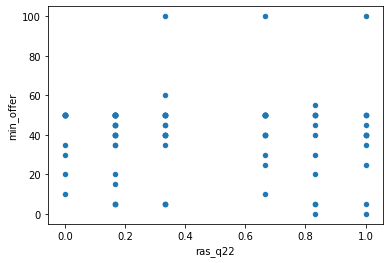

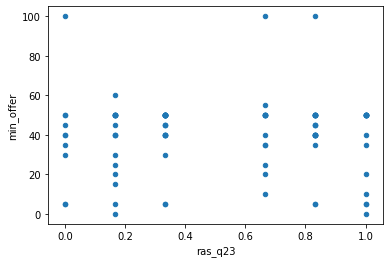

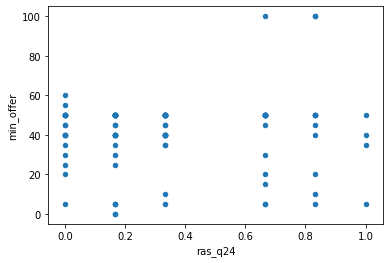

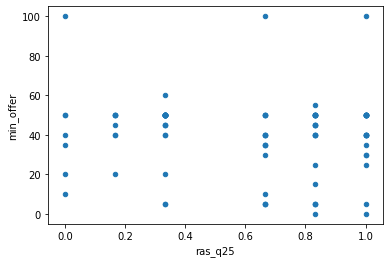

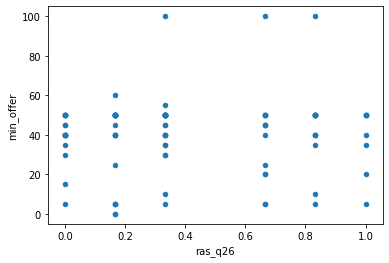

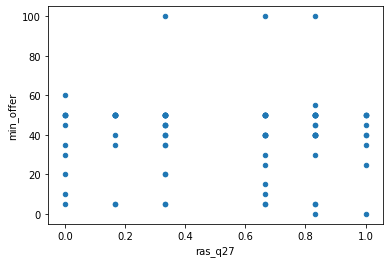

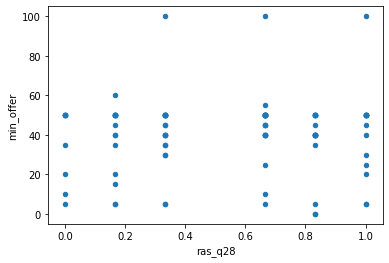

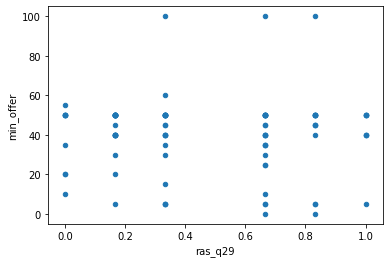

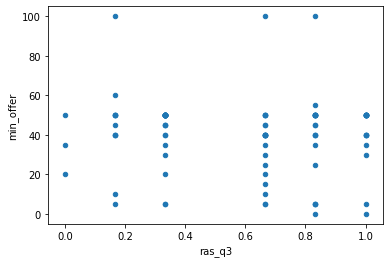

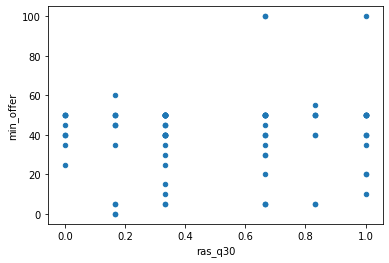

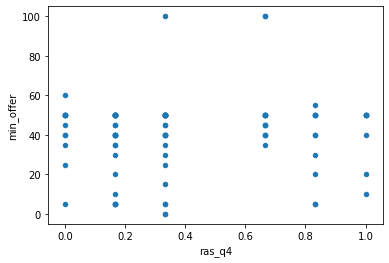

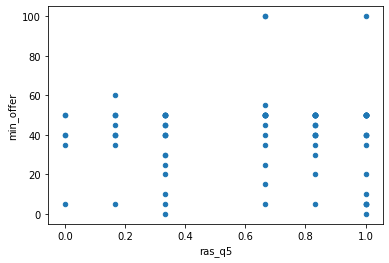

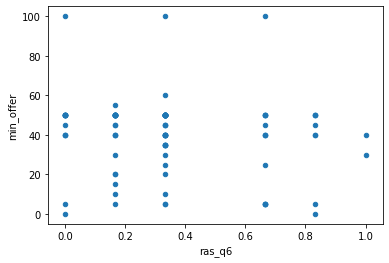

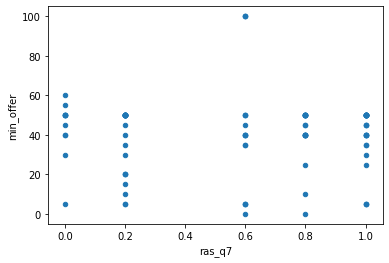

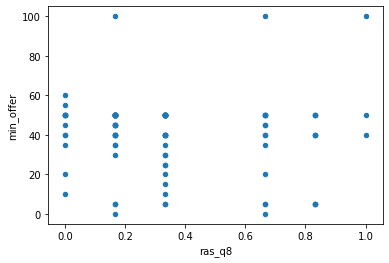

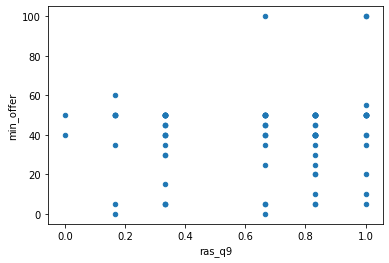

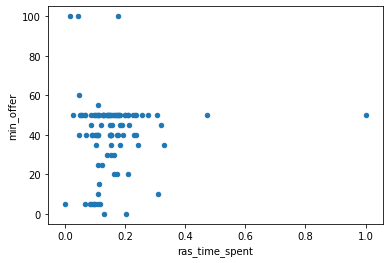

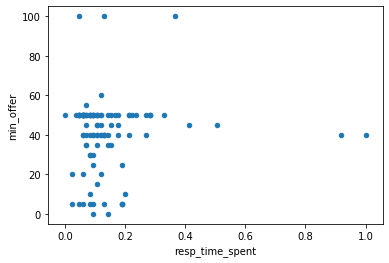

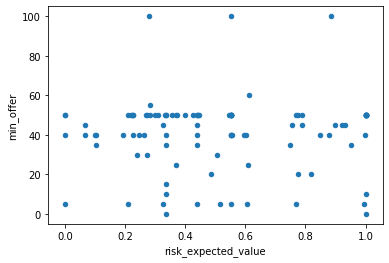

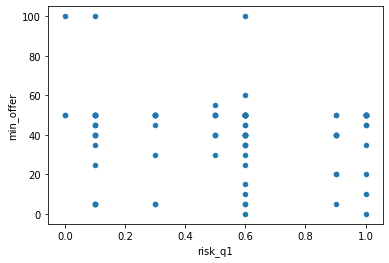

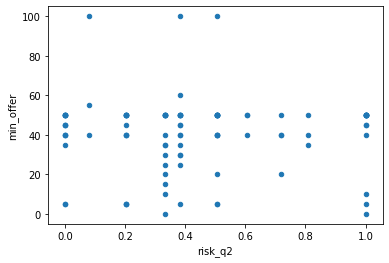

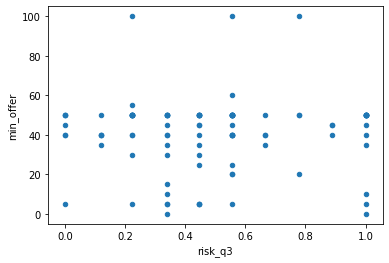

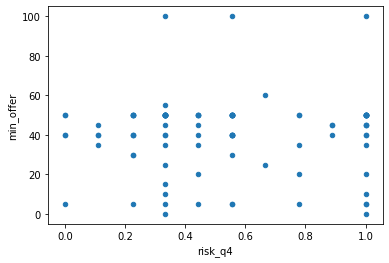

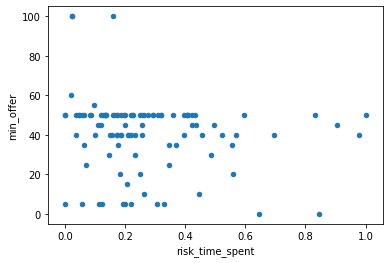

In [8]:
all_cols = list(df.columns)
if 'min_offer' in all_cols:
    all_cols.remove('min_offer')
for col in all_cols:
    if col == 'effort':
        x, y = df_to_xy(df, select_columns=[col])
    else:
        x, y = df_to_xy(df, select_columns=[col])
    x = x.ravel()
    y = y.ravel()
    out_df = pd.DataFrame.from_dict({col:x, 'min_offer':y})
    out_df.plot.scatter(x=col, y='min_offer')

In [28]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, BaggingRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from core.models import AcceptanceModel

split = int(x.shape[0] * 0.75)
xTrain = x[:split].reshape(-1, 1)
yTrain = y[:split]
xTest = x[split:].reshape(-1, 1)
yTest = y[split:]
model = MultinomialNB()
model.fit(xTrain, yTrain)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [29]:
yPred = model.predict(xTest)
yPred

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50])

In [30]:
yTest

array([  5,  40,  25,  50,  50,  50,  40,  50, 100,   5,  55,  45,  35,
        50,  45,  30,  50,  50,  15,  50,   5,  50,  50,  50,  50,  40])

In [34]:
from core.models.metrics import gain_mean, avg_loss_ratio
print("loss ratio: ", avg_loss_ratio(yTest, yPred))
gain_mean(yTest, yPred)

loss ratio:  0.2063250911190898


46.15384615384615

In [35]:
import numpy as np
import pandas as pd
from core.models.metrics import loss

@np.vectorize
def sigmoid1024(x):
    base = 2000.0**2
    return (base**x/(base**x + 1))

@np.vectorize
def loss_derivable(x, offset=1,  div1=8, div2=20):
    x1 = (x + offset) / div1
    x2 = (x) / div2
    return (1 - sigmoid1024(x1) *  np.cos(x2/np.pi))

def gain_derivable(x):
    return 1 - loss(x)

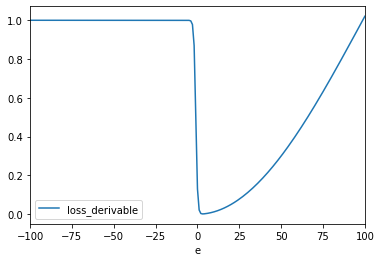

In [55]:
x = np.arange(-100, 101, 1)
y_derivable = loss_derivable(x)

out_df = pd.DataFrame({'e':x, 'loss_derivable':y_derivable})
out_df.plot.line(x='e', y='loss_derivable')

In [58]:
out_df.iloc[:]*100

,e,loss_derivable
0,-10000,100.000000
1,-9900,100.000000
2,-9800,100.000000
3,-9700,100.000000
4,-9600,100.000000
5,-9500,100.000000
6,-9400,100.000000
7,-9300,100.000000
8,-9200,100.000000
9,-9100,100.000000


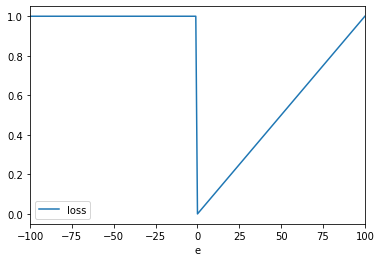

In [42]:
x = np.arange(-100, 101, 1)
y = loss(0, x) / 100

out_df = pd.DataFrame({'e':x, 'loss':y})
out_df.plot.line(x='e', y='loss')

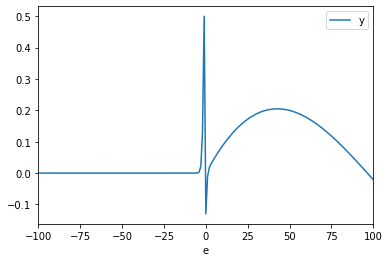

In [44]:
tmp_df = pd.DataFrame({'e':x, 'y': y - y_derivable})
tmp_df.plot.line(x='e', y='y')

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


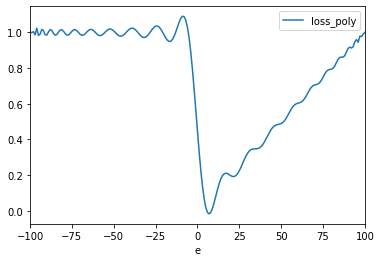

In [51]:
degs = np.polyfit(x, y, deg=150)
loss_poly = np.poly1d(degs)
y_poly = loss_poly(x)
tmp2_df = pd.DataFrame({'e':x, 'loss_poly': y_poly})
tmp2_df.plot.line(x='e', y='loss_poly')